In [1]:
import MGTomo.model as mgmodel
import time
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch, box_bounds

from MGTomo.gridop import P,R, RBox, PBox

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 3
maxIter = [1,5,5,5,5]

In [3]:
N = 511
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
#c0 = A[0].sumnorm()
#tau0 = 0.5 * 1/c0

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [7]:
#c0 = 56.0952
#tau0 = 0.5 * 1/c0

c0 = 100
tau0 = 0.5 * 1/c0

In [8]:
tau = [tau0]*(max_levels+1)

In [9]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        y_norm = matrix_norm(y, ord = 1)
        return gcond and (y_diff_norm >= eta * y_norm)
    else:
        #print('y_last was none')
        return gcond

In [10]:
def coarse_condition_v3(grad_y, kappa, eps):
    Rgrady = matrix_norm( R(grad_y), ord = 1)
    gcond_rel = (Rgrady >= kappa * matrix_norm(grad_y, ord = 1))
    gcond = (Rgrady >= eps)
    
    return gcond_rel and gcond

In [11]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(0.25 * R(grad_y), ord = 1) >= kappa * matrix_norm(grad_y, ord = 1))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y, ord = 1)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond

In [12]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.47, eps = 1e-3, verbose = True):
    x = R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    #print('coarse correction at l = ', l)
    #if coarse_condition(y, grad_fhy0, kappa, last_pts[l]):
    if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        #print('kl(y^*, y^k): ', fcts.kl_distance_no_matrix(x_torch, y0))

        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y0, x, P_inf, lh, uh)

        assert torch.all((uH - lH) >= 0)

        logvH_new = mylog(x - lH) - mylog(uH - x)
        assert not torch.any(torch.isnan(logvH_new))
        for i in range(maxIter[l]):
            x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts, _ = MLO_box(psi, x,lH, uH, last_pts, l+1, verbose=verbose)

        #assert psi(x) <= fH(x0) + torch.sum(kappa * x0), 'psi(x) < psi(x0) = fH(x0) does not hold'
    else: 
        print(l, ' : coarse correction not activated')
    
    #print('back on level: ', l)
    d = P(x-x0)
    z, a = armijo_linesearch(fh, y0, d)
    #print('kl(y^*, z): ', fcts.kl_distance_no_matrix(x_torch, z))
    
    #assert z.min() >= 0, z.min()

    logvh_new = mylog(z - lh) - mylog(uh - z)
    
    for i in range(maxIter[l]):
        z.retain_grad()
        zval, logvh_new = fcts.BSMART_general(fh, z, logvh_new, tau[l], lh, uh)
        y0.grad.zero_()
        z = zval.clone().detach().requires_grad_(True)
    #print('kl(y^*, y^k+1): ', fcts.kl_distance_no_matrix(x_torch, z))
    return z, last_pts, a


In [13]:
P_inf = 8.0
a = []
z0 = torch.rand(N, N, requires_grad = True)
w0 = z0.clone().detach().requires_grad_(True)
fhz0 = fh(z0).item()
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)


iteration_times_ML = []
overall_start_time_ML = time.process_time()  # Start overall timing

fval_ML = []

for i in range(100):
    iteration_start_time_ML = time.process_time()  # Start timing for this iteration
    
    val, ylast, alpha = MLO_box(fh, z0, lh, uh, last_pts, verbose=False)
    z0 = val.clone().detach().requires_grad_(True)
    a.append(alpha)
    
    iteration_end_time_ML = time.process_time()  # End timing for this iteration
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML  # Calculate elapsed time for this iteration
    iteration_times_ML.append(iteration_time_ML)

    fval_ML.append(fh(z0).detach().numpy()/fhz0)
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.process_time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 0: 437024.42072332953 - Time: 68.716583 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 1: 284596.9359314521 - Time: 72.930649 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 2: 201872.36659356495 - Time: 74.407669 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 3: 152116.09738481874 - Time: 73.895295 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 4: 119625.98710674913 - Time: 73.662380 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
Iteration 5: 97087.16302643686 - Time: 73.811143 seconds
0  : coarse correction activated
1  : coarse correction acti

In [14]:
iteration_times_SL = []
overall_start_time_SL = time.process_time()  # Start overall timing

fval_SL = []

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.process_time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, tau0, lh, uh)
    w0 = val.clone().detach().requires_grad_(True)
    
    iteration_end_time_SL = time.process_time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    iteration_times_SL.append(iteration_time_SL)

    fval_SL.append(fh(w0).item()/fhz0)
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.process_time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 4580987.644673146 - Time: 5.739902 seconds
Iteration 1: 3551728.829530797 - Time: 5.735117 seconds
Iteration 2: 2854574.4031685004 - Time: 5.713060 seconds
Iteration 3: 2339287.2172035323 - Time: 7.072316 seconds
Iteration 4: 1942016.980716681 - Time: 5.738049 seconds
Iteration 5: 1628523.185203805 - Time: 5.737379 seconds
Iteration 6: 1380541.0508454533 - Time: 5.740144 seconds
Iteration 7: 1183868.1304320502 - Time: 5.737328 seconds
Iteration 8: 1026060.9669330067 - Time: 5.813137 seconds
Iteration 9: 898626.0761164874 - Time: 5.712732 seconds
Iteration 10: 795393.1190142164 - Time: 5.688085 seconds
Iteration 11: 711050.2077081841 - Time: 5.740652 seconds
Iteration 12: 641382.4420219049 - Time: 5.734483 seconds
Iteration 13: 583182.7589026073 - Time: 5.736186 seconds
Iteration 14: 534133.2038977738 - Time: 5.720130 seconds
Iteration 15: 492467.63727437035 - Time: 5.743170 seconds
Iteration 16: 456800.8608491775 - Time: 5.738257 seconds
Iteration 17: 426030.08997362957 - 

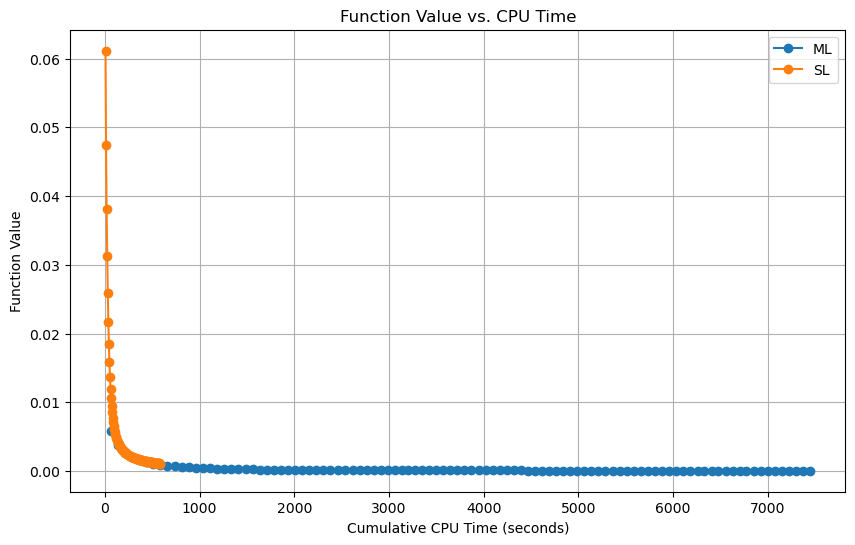

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

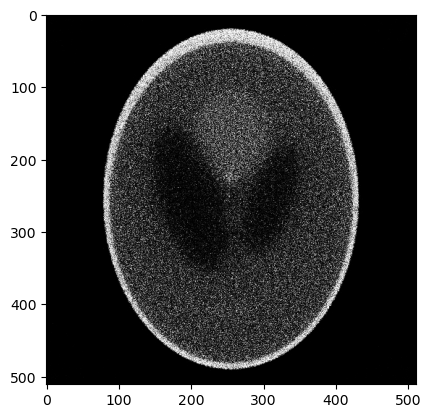

In [18]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')